In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import matplotlib_venn as venn
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

In [21]:
color = sns.color_palette()
eng_stopwords = set(stopwords.words("english"))
tokenizer = TweetTokenizer()
lem = WordNetLemmatizer()

In [7]:
train = pd.read_csv(r'C:\Users\Nino\Documents\Python Scripts\Toxic Comments\train.csv')
test = pd.read_csv(r'C:\Users\Nino\Documents\Python Scripts\Toxic Comments\test.csv')

In [8]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


Text(0.5, 0, 'Label ')

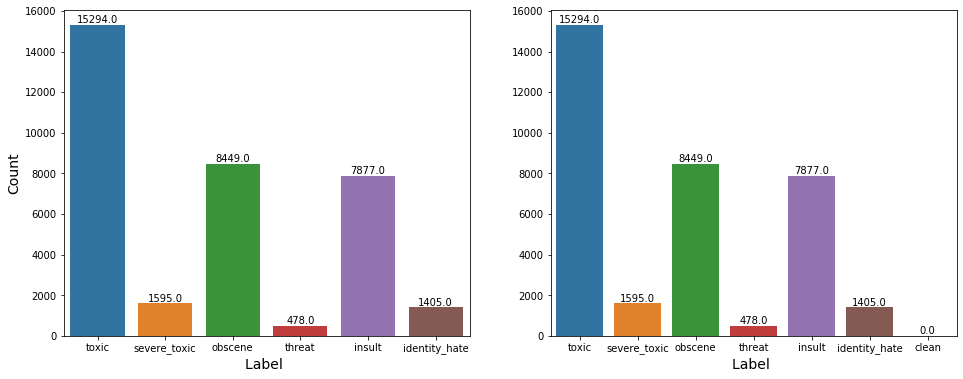

In [15]:
# It looks like a comment can have multiple classifications (ie being toxic as well as obscene and an insult).
rowsums = train.iloc[:, 2:].sum(axis=1)
train['clean'] = (rowsums == 0)

w = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].iloc[:].sum(axis=0)
x = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'clean']].iloc[:].sum(axis=0)


fig, ax = plt.subplots(1,2, figsize=(16,6))
a = sns.barplot(w.index, w.values, ax=ax[0])
b = sns.barplot(x.index, x.values, ax=ax[1])

rects = b.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    b.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')
    
rects = a.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    a.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')
    
a.set_ylabel('Count', fontsize=14)
a.set_xlabel('Label ', fontsize=14)
b.set_xlabel('Label ', fontsize=14)

Text(0.5, 0, 'Label ')

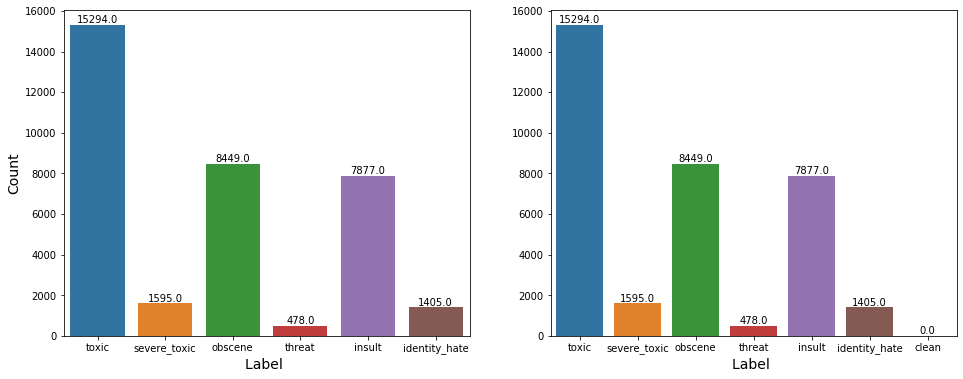

In [16]:
# As expected, the label counts are not evenly distributed. Toxic comments heavily outweight any other label, while threats are quite rare.

# However, toxic comments may have multiple labels.

w = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].iloc[:].sum(axis=0)
x = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'clean']].iloc[:].sum(axis=0)


fig, ax = plt.subplots(1,2, figsize=(16,6))
a = sns.barplot(w.index, w.values, ax=ax[0])
b = sns.barplot(x.index, x.values, ax=ax[1])

rects = b.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    b.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')
    
rects = a.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    a.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')
    
a.set_ylabel('Count', fontsize=14)
a.set_xlabel('Label ', fontsize=14)
b.set_xlabel('Label ', fontsize=14)

In [17]:
# Data cleanup and Feature Engineering

In [18]:
# Merge train & test dataset and reset index

merged = pd.concat([train.iloc[:, 0:2], test.iloc[:, 0:2]])
df = merged.reset_index(drop=True)

In [19]:
df

,id,comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember..."
...,...,...
312730,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
312731,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
312732,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
312733,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [29]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopword = set(STOPWORDS)

# Find the number of new lines '\n'
df['sentenceCount'] = df['comment_text'].apply(lambda x: len(re.findall("\n", str(x))) + 1)

# Number of words 
df['wordCount'] = df['comment_text'].apply(lambda x: len(str(x).split()))

# Unique number of words
df['uniqueWordCount'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))

# Number of letters
df['letterCount'] = df['comment_text'].apply(lambda x: len(str(x)))

# Punctuation count
df['puncCount'] = df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Number of uppercase words
df["uppercaseCount"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# Number of titled words (words starting with capital letter)
df["titleWordCount"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Number of stopwords
df["stopwordCount"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword]))

# Average word length
df["meanWordLength"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# Unique word count percentage
df['wordCountPercent'] = np.round(df['uniqueWordCount'] / df['wordCount'] * 100, 2)

# Punctuation percentage per comment
df['puncPercent'] = np.round(df['puncCount'] / df['wordCount'] * 100, 2)

c:\Users\Nino\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [32]:
df.head()

,id,comment_text,sentenceCount,wordCount,uniqueWordCount,letterCount,puncCount,uppercaseCount,titleWordCount,stopwordCount,meanWordLength,wordCountPercent,puncPercent
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,264,10,2,11,20,5.162791,95.35,23.26
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,112,12,1,3,3,5.588235,100.00,70.59
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,233,6,0,2,21,4.571429,92.86,14.29
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",5,113,82,622,21,5,7,58,4.486726,72.57,18.58
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,13,13,67,5,0,2,6,4.230769,100.00,38.46


In [30]:
# Seperate Train/Test data
trainFeatures = df.iloc[0:len(train)]
testFeatures = df.iloc[len(train) :,]

# Join tags
trainTags = train.iloc[:, 2:]
trainFeatures = pd.concat([trainFeatures, trainTags], axis=1)

In [ ]:
# Let's create our own Count Vectorizer to pick up specific items.

In [33]:
# Leaky features
df['IP'] = df["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", str(x)))

# Count of IP addresses
df['countIP'] = df["IP"].apply(lambda x: len(x))

# URLs
df['URL'] = df["comment_text"].apply(lambda x: re.findall("http://.*com",str(x)))

# Count of URLs
df['countURL'] = df["URL"].apply(lambda x: len(x))

# Article IDs
df['articleID'] = df["comment_text"].apply(lambda x: re.findall("\d:\d\d\s{0,5}$",str(x)))
df['articleIDFlag'] = df['articleID'].apply(lambda x: len(x))

# Username
df['username'] = df["comment_text"].apply(lambda x: re.findall("\[\[User(.*)\|",str(x)))

#count of username mentions
df['countUsernames'] = df["username"].apply(lambda x: len(x))

# check if features are created
# df.username[df.count_usernames>0]

# Leaky IP
cv = CountVectorizer()
count_feats_ip = cv.fit_transform(df["IP"].apply(lambda x : str(x)))


# Leaky usernames

cv = CountVectorizer()
count_feats_user = cv.fit_transform(df["username"].apply(lambda x : str(x)))

In [34]:
# Let's check some feature names

cv.get_feature_names()[100:115]

['color',
 'colorprobe',
 'condemn',
 'contribs',
 'contributions',
 'cool',
 'corvoe',
 'crash',
 'cyphoidbomb',
 'dalbury',
 'danielfolsom',
 'dante',
 'datbitch',
 'dc',
 'ddstretch']

In [36]:
df.head()

,id,comment_text,sentenceCount,wordCount,uniqueWordCount,letterCount,puncCount,uppercaseCount,titleWordCount,stopwordCount,...,wordCountPercent,puncPercent,IP,countIP,URL,countURL,articleID,articleIDFlag,username,countUsernames
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,264,10,2,11,20,...,95.35,23.26,[89.205.38.27],1,[],0,[],0,[],0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,112,12,1,3,3,...,100.00,70.59,[],0,[],0,[],0,[],0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,233,6,0,2,21,...,92.86,14.29,[],0,[],0,[],0,[],0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",5,113,82,622,21,5,7,58,...,72.57,18.58,[],0,[],0,[],0,[],0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,13,13,67,5,0,2,6,...,100.00,38.46,[],0,[],0,[],0,[],0


In [37]:
leaky_feats = df[["IP", "URL", "articleID", "username", "countIP","countURL","countUsernames","articleIDFlag"]]

leaky_feats_train = leaky_feats.iloc[:train.shape[0]]
leaky_feats_test = leaky_feats.iloc[train.shape[0]:]

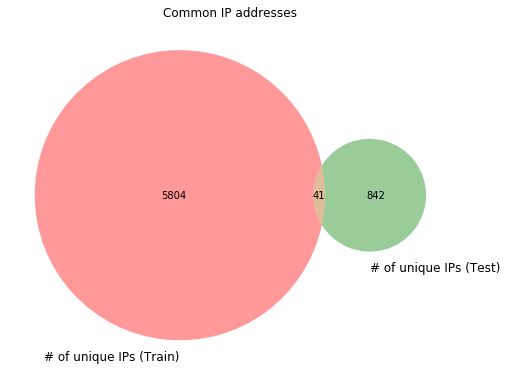

In [38]:
import matplotlib_venn as venn

# Filter out items that do not contain IPs
train_IPs = leaky_feats_train.loc[(leaky_feats_train['IP'].str.len() != 0)]
test_IPs = leaky_feats_test.loc[(leaky_feats_test['IP'].str.len() != 0)]

# Obtain list of unique IPs
train_IP_list = list(set([a for b in train_IPs['IP'].tolist() for a in b]))
test_IP_list = list(set([a for b in test_IPs['IP'].tolist() for a in b]))

# Obtain common elements
common_IP_list = list(set(train_IP_list).intersection(test_IP_list))

plt.figure(figsize=(8, 8))
plt.title("Common IP addresses")
venn.venn2(subsets=(len(train_IP_list), len(test_IP_list), len(common_IP_list)),
           set_labels=("# of unique IPs (Train)", "# of unique IPs (Test)"))
plt.show()

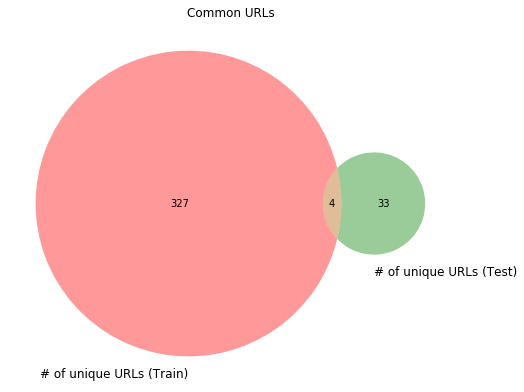

In [39]:
# Filter out items without URLs
train_URLs = leaky_feats_train.loc[(leaky_feats_train['URL'].str.len() != 0)]
test_URLs = leaky_feats_test.loc[(leaky_feats_test['URL'].str.len() != 0)]

# Obtain list of unique URLs
train_URLs_list = list(set([a for b in train_IPs['URL'].tolist() for a in b]))
test_URLs_list = list(set([a for b in test_IPs['URL'].tolist() for a in b]))

# Obtain common elements
common_URLs_list=list(set(train_URLs_list).intersection(test_URLs_list))

plt.figure(figsize=(8, 8))
plt.title("Common URLs")
venn.venn2(subsets=(len(train_URLs_list),len(test_URLs_list),len(common_URLs_list)),
           set_labels=("# of unique URLs (Train)","# of unique URLs (Test)"))
plt.show()

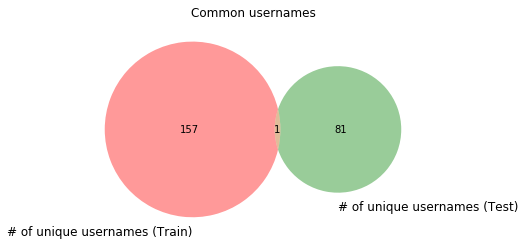

In [40]:
# Filter out items without usernames
train_users = leaky_feats_train['username'].loc[(leaky_feats_train['countUsernames'] != 0)]
test_users = leaky_feats_test['username'].loc[(leaky_feats_test['countUsernames'] != 0)]

# Obtain list of unique usernames
train_users_list = list(set([a for b in train_users.tolist() for a in b]))
test_users_list = list(set([a for b in test_users.tolist() for a in b]))
                        
# Obtain common elements
common_users_list = list(set(train_users_list).intersection(test_users_list))
                       
plt.title("Common usernames")
venn.venn2(subsets=(len(train_users_list),len(test_users_list),len(common_users_list)),
           set_labels=("# of unique usernames (Train)","# of unique usernames (Test)"))
plt.show()

In [41]:
# Aphost lookup dict
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [42]:
def cleanComment(comment):
    """Takes a comment and returns cleaned copy."""
    
    # Lower case
    comment = comment.lower()
    
    # Remove '\n'
    comment = re.sub('\\n', '', comment)
    
    # Remove IPs
    comment = re.sub('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', '', comment)
    
    # Remove username
    comment = re.sub('\[\[.*\]', '', comment)
    
    # Split comment (sentences) into words (tokens)
    words = tokenizer.tokenize(comment)
    
    # Replace apostrophes; you're --> you are  
    # using basic dictionary lookup 
    words = [APPO[word] if word in APPO else word for word in words]
    words = [lem.lemmatize(word, 'v') for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    cleaned = ' '.join(words)

    return(cleaned)

In [44]:
corpus = merged['comment_text']
corpus.iloc[12235]

'"\n\n NOTE If you read above, and follow the links, any reader can see that I cited correctly the links I added on this subject. Vidkun has added anotations to make them read as the oposite, but these links show the ""official"" line taken by UGLE. I will not be trapped by any User into so-called 3RR, so he can peddle his POV. Strangly, ALL other ""MASONS"" are quiet, leaving ‘‘me’’ to defend that factual truth on my own. ""Thanks"" Brethren. Sitting any blocking out if given...  "'

In [45]:
# Clean entire corpus

clean_corpus = corpus.apply(lambda x: cleanComment(x))